In [285]:
import numpy as np
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import math
from jax.typing import ArrayLike
import IPython.display
import time


class BasePlanarQuadrotor:

    def __init__(self):
        # Dynamics constants
        # yapf: disable
        self.x_dim = 6         # state dimension (see dynamics below)
        self.u_dim = 2         # control dimension (see dynamics below)
        self.g = 9.807         # gravity (m / s**2)
        self.m = 2.5           # mass (kg)
        self.l = 1.0           # half-length (m)
        self.Iyy = 1.0         # moment of inertia about the out-of-plane axis (kg * m**2)
        self.Cd_v = 0.25       # translational drag coefficient
        self.Cd_phi = 0.02255  # rotational drag coefficient
        # yapf: enable

        # Control constraints
        self.max_thrust_per_prop = 0.75 * self.m * self.g  # total thrust-to-weight ratio = 1.5
        self.min_thrust_per_prop = 0  # at least until variable-pitch quadrotors become mainstream :D

    def ode(self, state, control, np=jnp):
        """Continuous-time dynamics of a planar quadrotor expressed as an ODE."""
        x, v_x, y, v_y, phi, omega = state
        T_1, T_2 = control
        return np.array([
            v_x,
            (-(T_1 + T_2) * np.sin(phi) - self.Cd_v * v_x) / self.m,
            v_y,
            ((T_1 + T_2) * np.cos(phi) - self.Cd_v * v_y) / self.m - self.g,
            omega,
            ((T_2 - T_1) * self.l - self.Cd_phi * omega) / self.Iyy,
        ])

    def discrete_step(self, state, control, dt, np=jnp):
        """Discrete-time dynamics (Euler-integrated) of a planar quadrotor."""
        # RK4 would be more accurate, but this runs more quickly in a homework problem;
        # in this notebook we use Euler integration for both control and simulation for
        # illustrative purposes (i.e., so that planning and simulation match exactly).
        # Often simulation may use higher fidelity models than those used for planning/
        # control, e.g., using `scipy.integrate.odeint` here for much more accurate
        # (and expensive) integration.
        return state + dt * self.ode(state, control, np)
    
    def jacobian(self, state, control):
        """Jacobian matrix for the discrete-time dynamics."""
        x, v_x, y, v_y, phi, omega = state
        T_1, T_2 = control
        return np.array([
            [0, 1, 0, 0, 0, 0],
            [0, -self.Cd_v / self.m, 0, 0, -(T_1 + T_2) * np.cos(phi) / self.m, 0],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, -self.Cd_v / self.m, -(T_1 + T_2) * np.sin(phi) / self.m, 0],
            [0, 0, 0, 0, 0, 1],
            [0, 0, 0, 0, 0, -self.Cd_phi / self.Iyy]
        ])
    
class LinearizeDynamics:
    def __init__(self,dis_dyn,state,control,dt):
        self.dyn = dis_dyn
        self.state = state
        self.control = control
        self.dt = dt

        self.A = jax.jacfwd(self.dyn,argnums=0)(self.state,self.control,self.dt)
        self.B = jax.jacfwd(self.dyn,argnums=1)(self.state,self.control,self.dt)
        self.C = self.dyn(self.state,self.control,self.dt) -self.A@self.state -self.B@self.control
        
    def ld_dyn(self):
        return self.A@self.state + self.B@self.control + self.C
    
    def get_A(self):
        return self.A
    
    def get_B(self):
        return self.B
    
    def get_C(self):
        return self.C



In [287]:
s = np.array([1,2,3,4,5,6],dtype = float)
u = np.array([10,20],dtype=float)
planar_quad = BasePlanarQuadrotor()
print(jax.jacfwd(planar_quad.ode,argnums=0)(s,u))

print(planar_quad.jacobian(s,u))

[[ 0.         1.         0.         0.         0.         0.       ]
 [-0.        -0.1       -0.        -0.        -3.4039464 -0.       ]
 [ 0.         0.         0.         1.         0.         0.       ]
 [ 0.         0.         0.        -0.1       11.5070915  0.       ]
 [ 0.         0.         0.         0.         0.         1.       ]
 [-0.        -0.        -0.        -0.        -0.        -0.02255  ]]
[[ 0.          1.          0.          0.          0.          0.        ]
 [ 0.         -0.1         0.          0.         -3.40394623  0.        ]
 [ 0.          0.          0.          1.          0.          0.        ]
 [ 0.          0.          0.         -0.1        11.5070913   0.        ]
 [ 0.          0.          0.          0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.         -0.02255   ]]


In [307]:
def generate_deterministic_states_and_measurement(N, H:ArrayLike, dt, initial_state, controls): #no disturbance
    
    states = np.zeros((N+1, 6))
    states[0] = initial_state
    
    measurememts = np.zeros((N+1,H.shape[0]))
    measurememts[0] = H @ initial_state 
    
    
    for i in range(N):
        states[i+1] = planar_quad.discrete_step(states[i], controls[i], dt)
        measurememts[i+1] = H @ states[i+1]
        # print(f"{i}th angle", math.degrees(states[i+1][4]))

    return states,measurememts

def add_gaussian_noise(states,mu:ArrayLike,sigma:ArrayLike):
    m,n = states.shape
    
    for i in range(len(states)):
        error = np.sqrt(sigma) @ np.random.randn(n) + mu
        # print(error)
        states[i] = states[i] + error 

    return states

def EKF(control_sequence,mu,sigma,Q,H,R,N,dt):
    '''
    1. if add v and w in the dynamics, it will crash.
    2. how do we deal with the C term? it's not introduced in the KF framework.
    3. when setting covariance too small, it will generate problems
    '''
    m, n = H.shape #H: R^(3*6)  = y_shape * x_shape
    X_hat = np.zeros((N,n)) #estimated state
    P = np.zeros((N,n,n)) 

    v = np.sqrt(Q)@np.random.randn(n)
    w = np.sqrt(R)@np.random.randn(m)

    X = np.zeros((N,n))  #updated by linearized dynamics
    Y = np.zeros((N,m))
    
    X[0] = mu #+ np.sqrt(sigma)@np.random.randn(n)
    # X[0] = mu + np.sqrt(sigma)@np.random.randn(n)

    # Y[0] = H@initial_state  #Do we need to initialize anything?

    X_hat[0] = mu #initialize mean
    P[0] = sigma #initialize covariance matrix

    for i in range(N-1):
        #get linearized A and B at each point
        lin_dyn = LinearizeDynamics(planar_quad.discrete_step,X[i],control_sequence[i],dt)  ####now linearize at X#####

        A = lin_dyn.get_A()
        B = lin_dyn.get_B()
        C = lin_dyn.get_C()
        X[i+1] = lin_dyn.ld_dyn() + v
        Y[i+1] = H@X[i+1] + w
        # X[i+1] = lin_dyn.ld_dyn()
        # Y[i+1] = H@X[i+1]

        Xhat_pred = A@X_hat[i] + B @ control_sequence[i] + C
        P_pred = A@P[i]@A.T 
        S = H@P[i]@H.T + R
        S_inv = np.linalg.inv(S)  
        K = P_pred@H.T@S_inv
        X_hat[i+1] = Xhat_pred + K@(Y[i+1]-H@Xhat_pred)
        P[i+1] = P_pred - K@S@K.T
    
    return X_hat,X


In [291]:
#plotting

def plot_traj(state_sequence): #input a N*6*1 matrix, will prinit out as animation
    N = len(state_sequence)

    plt.figure()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Trajectory')

    # def roataion_mat(angle,vector):  #counter clockwise rotation
    #     return np.array([[np.cos(angle),-np.sin(angle)],
    #                      [np.sin(angle), np.cos(angle)]])  @ vector 
    
    def rotaion(angle, vector):  # counter-clockwise rotation
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                  [np.sin(angle), np.cos(angle)]])
        return rotation_matrix @ vector

    for i in range(N):
        plt.plot(state_sequence[:i+1, 0], state_sequence[:i+1, 2])
         
        #body frame x arrow
        x_arrow = rotaion(state_sequence[i,4],np.array([1,0]))
        plt.quiver(state_sequence[i,0], state_sequence[i,2], x_arrow[0], x_arrow[1], scale=15, color='red')
        #body frame y arrow
        y_arrow = rotaion(state_sequence[i,4],np.array([0,1]))
        plt.quiver(state_sequence[i,0], state_sequence[i,2], y_arrow[0], y_arrow[1], scale=15, color='blue')
        
        # plt.xlim([-2, 15])
        # plt.ylim([5, 10])
        IPython.display.clear_output(wait=True)
        display(plt.gcf())
        time.sleep(0.01)
        plt.clf()  # Clear the current figure

### initialize variables

In [265]:
#548 sequence
#50 k_controls

k_controls = np.array([[12.94349588, 12.97691164], 
       [12.92116354, 12.94490242],
       [12.89679699, 12.91398908],
       [12.87103051, 12.88351406],
       [12.84465181, 12.85266965],
       [12.81850192, 12.82059408],
       [12.79339224, 12.78645827],
       [12.77001642, 12.74955271],
       [12.74885155, 12.70938729],
       [12.73004465, 12.66580248],
       [12.71329318, 12.61908956],
       [12.69773434, 12.57009592],
       [12.68186434, 12.52029691],
       [12.66352302, 12.47180147],
       [12.63997233, 12.427266  ],
       [12.60810796, 12.38968941],
       [12.56481901, 12.36207806],
       [12.50749652, 12.34698935],
       [12.43464627, 12.34598717],
       [12.34652004, 12.35906655],
       [12.24561336, 12.38417606],
       [12.13688087, 12.41688802],
       [12.02756034, 12.4503671 ],
       [11.92652716, 12.47570427],
       [11.84325934, 12.4827875 ],
       [11.78650149, 12.46172228],
       [11.76270047, 12.40455777],
       [11.77460418, 12.30737214],
       [11.81998633, 12.17222878],
       [11.8907987 , 12.00857708],
       [11.97267514, 11.83319242],
       [12.08548669, 11.71521207],
       [12.22180289, 11.67918489],
       [12.32154746, 11.68221583],
       [12.38189322, 11.72436274],
       [12.40662854, 11.80053552],
       [12.40438442, 11.90243045],
       [12.3863155 , 12.02027938],
       [12.3638027 , 12.14432001],
       [12.34661088, 12.26597365],
       [12.34176122, 12.37869427],
       [12.35316205, 12.47843004],
       [12.38187299, 12.56365004],
       [12.42678805, 12.63496466],
       [12.48550532, 12.69444487],
       [12.55519262, 12.74479798],
       [12.63332968, 12.78857542],
       [12.71824494, 12.82754857],
       [12.80940457, 12.86235206],
       [12.9073966 , 12.8924723 ]])
k_dt = 0.17069465800865732
# k_dt = 0.1
#k_controls, x0
k_N = len(k_controls)

In [310]:
N = 200
dt = 0.1

np.random.seed(1)
control_sequence = np.random.normal(20,0.1,(N,2))


x0 = np.array([0,0,5,0,0,0])  #mu = x0
sigma = np.eye(6)*0.00001
Q = np.eye(6)*0.0001
R = np.eye(3)*0.0001
H = np.array([[1,0,0,0,0,0],   #x_pos
              [0,0,1,0,0,0],   #y_pos
              [0,0,0,0,1,0]])  #psi


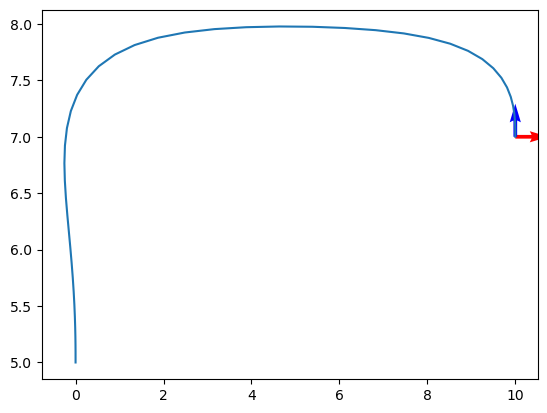

<Figure size 640x480 with 0 Axes>

In [304]:
det_states = generate_deterministic_states_and_measurement(k_N,H,k_dt,x0,k_controls)[0]
dist_states = add_gaussian_noise(det_states.copy(),np.zeros(6),Q)

plot_traj(det_states)
# plot_traj(dist_states)

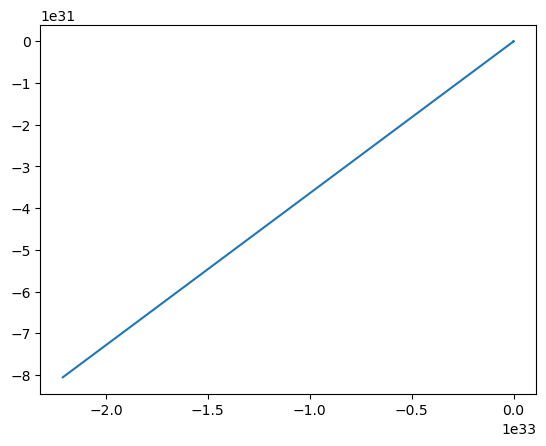

In [311]:
extended = EKF(k_controls,x0,sigma,Q,H,R,k_N,k_dt)

state_hat = extended[0]  
state = extended[1]

# plot_traj(state_hat)
plt.plot(state_hat[:,0],state_hat[:,2])
# plt.plot(state[:,0],state[:,2])

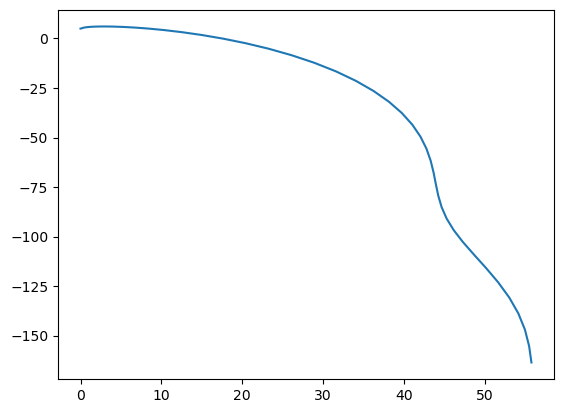

In [309]:
plt.plot(state[:,0],state[:,2])